# Info 4700 Capstone: Machine Learning and Dataset Building

In [2]:
#Imports
import pandas as pd
import numpy as np
from skimage.io import imread
import skimage

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Reading CSV File from Labelling Spectrogram

This CSV file was created by a crowd-sourced labelling process in the Capstone class. Each file has the Google Drive link, the label given to the picture, and the new 'correct' label.

In [3]:
drive_and_label = pd.read_excel('Specogram Processing\Spectogram_Data_v1.xlsx')
drive_and_label.head()

,Spectogram,Meta_Label,New_Label
0,https://drive.google.com/uc?export=download&id...,320kpbs,192 kbps (LAME)
1,https://drive.google.com/uc?export=download&id...,320 kbps,320 kbps (LAME)
2,https://drive.google.com/uc?export=download&id...,320 kbps,128 kbps (CBR)
3,https://drive.google.com/uc?export=download&id...,128 kbps,128 kpbs (AAC)
4,https://drive.google.com/uc?export=download&id...,320 kbps,128 kbps (LAME)


## Calculating 'score' by picture
Here we are giving an overall score to each picture. We are trying to get an overall sense of how many black pixels there are by locating the shelf of the spectrogram.

Below is an example of what we're trying to use machine learning to label.

C:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


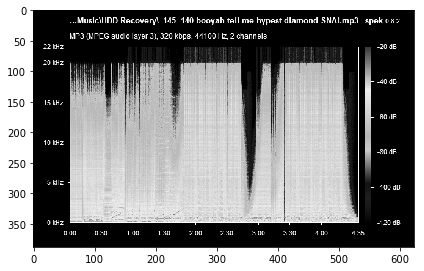

In [6]:
im = imread(drive_and_label.iloc[0]['Spectogram'], as_grey = True)
skimage.io.imshow(im)

## Creating Features from the Google Drive links.

Here we crop the picture and then give each column a 'score' as to how good the column is. We start at position 0 on the X and Y axis. From there, we look at the first column of pixels and loop downward to the bottom of the picture.

The if the shelf of the spectrogram is higher, there are going to be more non-black pixels in that column. So, in each column, if the pixel value is 0.0 (black) we reduce the score of that column by 1. If any pixel in the column does not equal 0.0 we give the score plus one. 

So, a column with a higher score in genral should give a higher quality.

**Note this loop takes a while to run since it has to access the GD links and create 624 features per image.**

In [92]:
#https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image/39382475
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2) 
    return img[starty:starty+cropy,startx:startx+cropx]

d = {}

for idx, row in drive_and_label.iterrows():
    #Find picture from GD link
    im = imread(row['Spectogram'], as_grey = True)

    #Crop Picture to get rid of top section
    #58 pixels is the standard header
    im = im[58:]

    #Find Bounds of image (to give baseline)
    y_bound, x_bound = im.shape

    #Looping across the x-axis (predefined resolution)
    final_score = []
    for ii in range(0, x_bound-1):
        #Reset Score per-coluimn
        score = 0
        for jj in range(0, y_bound-1): #Loop down each "x column"
            try:
                if im[ii, jj] == 0:
                    score -= 1
                elif im[ii,jj] != 0:
                    score += 1
            except:
                'IndexError'

        final_score.append(score)
    d[idx] = final_score 

In [10]:
df = pd.DataFrame.from_dict(d)
df = df.T
df.insert(0, 'label', drive_and_label['New_Label'])
df.tail()

df.to_csv('Spectogram Processing\SCORE_v1.csv', sep = ',')

NameError: name 'd' is not defined

In [36]:
df = pd.read_csv('Python_ML\SCORE_v1.csv')
df.tail()

,label,0,1,2,3,4,5,6,7,8,...,613,614,615,616,617,618,619,620,621,622
968,192 kbps (CBR),-287,-289,253,-171,-185,-163,-217,-225,-221,...,0,0,0,0,0,0,0,0,0,0
969,128 kbps (CBR),-287,-289,253,-49,-49,-29,-81,-85,-83,...,0,0,0,0,0,0,0,0,0,0
970,320 kbps (LAME),-287,-289,253,-189,-207,-181,-239,-243,-237,...,0,0,0,0,0,0,0,0,0,0
971,256 kbps (AAC),-287,-289,253,-89,-109,-83,-145,-143,-141,...,0,0,0,0,0,0,0,0,0,0
972,128 kbps (CBR),-287,-289,253,-247,-251,-233,-291,-291,-293,...,0,0,0,0,0,0,0,0,0,0


## Transforming Data for Machine Learning 

Here we are creating the training and testing datasets, as well as, using Z-Score normalization to standardize the data.

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scalar = StandardScaler()

In [65]:
#Using train test split to randomly assign data to training or testing
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], 
                                    df.iloc[:,0], test_size = 0.2)

#Standardizing X values with Z-score-standardization
scalar.fit(X_train)
X_train = scalar.transform(X_train)

scalar.fit(X_test)
X_test = scalar.transform(X_test)

This is a dummy classifier which uses a very simple algorithm to give us a baseline to improve off of.

In [67]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

classifier = DummyClassifier(strategy='most_frequent')

classifier.fit(X_train, y_train)

print("Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))

Training accuracy: 0.138817
Testing accuracy: 0.138817


## K-Fold Cross Validation

K-fold cross validation chunks our data into bins and allows for a consice way to test different algoriothms so we know which ones to improve.

In [41]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

LR: 0.271245 (0.056546)
KNN: 0.224892 (0.030155)
TREE: 0.190243 (0.039728)
SVM: 0.321262 (0.039145)


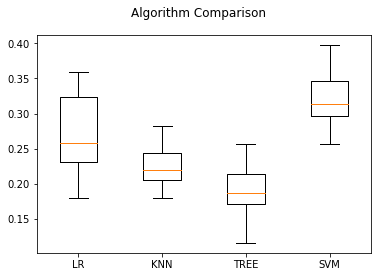

In [71]:
# prepare configuration for cross validation test harness
seed = 123
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#models.append(('Naive Bayes', GaussianNB))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Tuning the SVM Model

Since we can see out of LogisticRegression, KNN, Decision Tree, and SVM, the SVM is the highest. This means we can tune the hyper parameters of the SVM to see if we can improve off of 32% testing accuracy.

In [83]:
from sklearn.svm import SVC
train_max = []
test_max = []
switch = False
for kernel in ['linear', 'poly', 'poly', 'rbf']:
    print('--- Using a {} kernel ---'.format(kernel))
    for c_iter in [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]:
        #Init Classifier given kernel
        if kernel == 'poly' and switch == False:
            classifier = SVC(kernel=kernel, degree = 2, C=c_iter, random_state=123)
            if c_iter == 1000.0:
                switch = True #done with first poly move to second
        elif kernel == 'poly' and switch == True:
            classifier = SVC(kernel=kernel, degree = 3, C=c_iter, random_state=123)
        else:
            classifier = SVC(kernel=kernel, C=c_iter, random_state=123)
        
        #Fit classifier
        classifier.fit(X_train, y_train)
        
        #Find Accuracy
        print('C = {}'.format(c_iter))
        
        print("Training accuracy: %0.6f" % accuracy_score(y_train, classifier.predict(X_train)))
        print("Test accuracy: %0.6f" % accuracy_score(y_test, classifier.predict(X_test)))
        train_max.append(accuracy_score(y_train, classifier.predict(X_train)))
        test_max.append(accuracy_score(y_test, classifier.predict(X_test)))
                            

        
        
        

--- Using a linear kernel ---
C = 0.0001
Training accuracy: 0.197943
Test accuracy: 0.200000
C = 0.001
Training accuracy: 0.312339
Test accuracy: 0.302564
C = 0.01
Training accuracy: 0.334190
Test accuracy: 0.287179
C = 0.1
Training accuracy: 0.394602
Test accuracy: 0.266667
C = 1.0
Training accuracy: 0.556555
Test accuracy: 0.312821
C = 10.0
Training accuracy: 0.795630
Test accuracy: 0.282051
C = 100.0
Training accuracy: 0.970437
Test accuracy: 0.235897
C = 1000.0
Training accuracy: 0.997429
Test accuracy: 0.225641
--- Using a poly kernel ---
C = 0.0001
Training accuracy: 0.138817
Test accuracy: 0.128205
C = 0.001
Training accuracy: 0.147815
Test accuracy: 0.138462
C = 0.01
Training accuracy: 0.149100
Test accuracy: 0.138462
C = 0.1
Training accuracy: 0.155527
Test accuracy: 0.153846
C = 1.0
Training accuracy: 0.275064
Test accuracy: 0.256410
C = 10.0
Training accuracy: 0.338046
Test accuracy: 0.297436
C = 100.0
Training accuracy: 0.419023
Test accuracy: 0.297436
C = 1000.0
Training a

In [85]:
np.amax(train_max)
np.amax(test_max)

0.3128205128205128